Import necessary libaries

In [139]:
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
from unidecode import unidecode
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate,learning_curve,cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import SGDClassifier,SGDRegressor,LogisticRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/natedrake7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Pre-Processing

In [140]:
train_data = pd.read_csv('./Data/train_set.csv')
test_data = pd.read_csv('./Data/test_set.csv')

train_set = pd.DataFrame(train_data)
test_set = pd.DataFrame(test_data)

labels_to_drop = ['Party','New_ID']
train_set = train_set.drop(columns=labels_to_drop)
test_set = test_set.drop(columns=labels_to_drop)

train_set['Text'] = train_set['Text'].str.lower() #Make text lowercase
test_set['Text'] = test_set['Text'].str.lower() #Make text lowercase

stop = stopwords.words('greek')
pat = r'\b(?:{})\b'.format('|'.join(stop)) #regex expression

train_set['Text'] = train_set['Text'].str.replace(pat,'',regex=True) #apply regex expr to remove stopwords
test_set['Text'] = test_set['Text'].str.replace(pat,'',regex=True) #apply regex expr to remove stopwords

train_set['Text'] = train_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces
test_set['Text'] = test_set['Text'].str.replace(r'\s+',' ',regex=True) #remove multiple whitespaces

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','',x)) #remove links


def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

train_set['Text'] = train_set['Text'].apply(remove_accents) #remove accents
test_set['Text'] = test_set['Text'].apply(remove_accents) #remove accents

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE)) #replace non greek words with white space      
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'[^α-ωΑ-Ω0-9\s]', ' ', x, flags=re.UNICODE)) #replace non greek words with white space  

train_set['Text'] = train_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))
test_set['Text'] = test_set['Text'].apply(lambda x: re.sub(r'^RT[\s]+', '', x))


Vectorization and Label Encoding

In [155]:
vectorizer = TfidfVectorizer()
encoder = LabelEncoder()

#train_set = train_set.head(40000)


X_train = vectorizer.fit_transform(train_set['Text'])
X_test = vectorizer.fit_transform(test_set['Text'])

Y_train = encoder.fit_transform(train_set['Sentiment'])


Classification:

Stohastic Gradient Descent

In [142]:
clf = SGDClassifier(loss="log_loss", penalty="l2",max_iter= 40)
scoring = { #Create a Dictionary to store the scoring methods
    'precision': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall': make_scorer(recall_score, average='weighted', zero_division=1),
    'f_measure': make_scorer(f1_score, average='weighted', zero_division=1),
    'accuracy': make_scorer(accuracy_score)
}

warnings.filterwarnings('ignore',category=UserWarning) #ignore the warning that df['description] is 1 column
scores = cross_validate(clf, X_train, Y_train, cv=10, scoring=scoring) #perfrom 10 fold cross validation and return the results for the scoring methods specified above
print("Precision:", scores['test_precision'].mean()) #print the average precision from the 10 tests
print("Recall:", scores['test_recall'].mean()) #prin the average recall from the 10 tests
print("F-measure:", scores['test_f_measure'].mean()) #print the average f measure from the 10 tests
print("Accuracy:", scores['test_accuracy'].mean()) #print the average accuracy from the 10 tests



Precision: 0.3880666862421376
Recall: 0.3871962871962872
F-measure: 0.3862358456046239
Accuracy: 0.3871962871962872


$
\begin{array}{|c|c|c|c|c|c|}
\hline
 \text{Classifier} & \text{Loss} & \text{Penalty} & \text{Max Iterations} & \text{Average} & \text{Accuracy}\\
\hline
\text{SGD} & \text{log loss} & \text{L2} & \text{12} & \text{false} & \text{38.5\%}\\
\hline
\text{SGD} & \text{log loss} & \text{L2} & \text{20} & \text{false} & \text{38.7\%}\\
\hline
\text{SGD} & \text{log loss} & \text{L2} & \text{40} & \text{false} & \text{38.7\%}\\
\hline
\text{SGD} & \text{log loss} & \text{L2} & \text{100} & \text{false} & \text{38.7\%}\\
\hline
\text{SGD} & \text{log loss} & \text{L1} & \text{20} & \text{false} & \text{38.5\%}\\
\hline
\text{SGD} & \text{log loss} & \text{Elasticnet} & \text{20} & \text{false} & \text{38.7\%}\\
\hline
\text{SGD} & \text{log loss} & \text{L2} & \text{20} & \text{true} & \text{38.69\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L2} & \text{12} & \text{false} & \text{38.0\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L2} & \text{20} & \text{false} & \text{38.0\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L2} & \text{40} & \text{false} & \text{38.0\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L2} & \text{100} & \text{false} & \text{38.1\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L1} & \text{100} & \text{false} & \text{36.5\%}\\
\hline
\text{SGD} & \text{hinge} & \text{Elasticnet} & \text{100} & \text{false} & \text{37.6\%}\\
\hline
\text{SGD} & \text{hinge} & \text{L2} & \text{100} & \text{true} & \text{38.1\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{12} & \text{false} & \text{38.2\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{20} & \text{false} & \text{38.1\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{40} & \text{false} & \text{38.2\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{100} & \text{false} & \text{38.1\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{200} & \text{false} & \text{38.17\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L2} & \text{200} & \text{false} & \text{38.17\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L1} & \text{200} & \text{false} & \text{38.39\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L1} & \text{250} & \text{false} & \text{38.4\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L1} & \text{300} & \text{false} & \text{38.09\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L1} & \text{400} & \text{false} & \text{38\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{Elasticnet} & \text{40} & \text{false} & \text{38.14\%}\\
\hline
\text{SGD} & \text{modified huber} & \text{L1} & \text{250} & \text{true} & \text{31.1\%}\\
\hline
\end{array}
$

Learning Curve

In [168]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, Y_train, cv=20, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
print(train_sizes)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


[  347  1051  1754  2457  3160  3863  4566  5269  5972  6675  7378  8081
  8784  9487 10190 10893 11596 12300 13003 13706 14409 15112 15815 16518
 17221 17924 18627 19330 20033 20736 21439 22142 22845 23549 24252 24955
 25658 26361 27064 27767 28470 29173 29876 30579 31282 31985 32688 33391
 34094 34798]


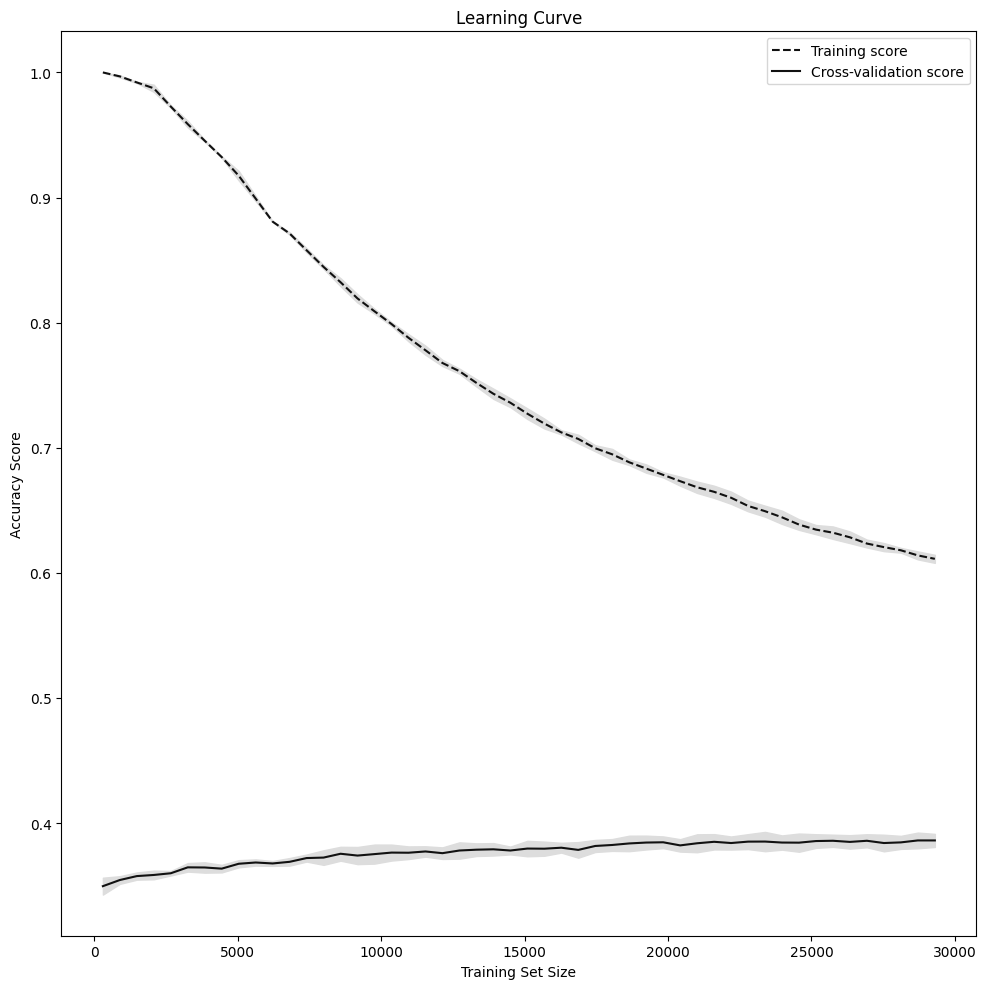

In [167]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()